<a href="https://colab.research.google.com/github/ThokozileKhosa/COS801_Project/blob/main/COS801_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense, BatchNormalization
from keras import layers, models
from keras.regularizers import l2
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import cv2

class FrameProcessor:
    def __init__(self, target_size=(64, 64)):
        self.target_size = target_size

    def extract_frames(self, video_path, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_resized = cv2.resize(frame, self.target_size)
            frame_filename = os.path.join(output_dir, f"frame{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame_resized)
            frame_count += 1

        cap.release()
        print(f"Extracted {frame_count} frames from {video_path} to {output_dir}.")

    def preprocess_frames(self, frame_paths):
        frames = []
        for frame_path in frame_paths:
            img = load_img(frame_path, target_size=self.target_size)
            img = img_to_array(img) / 255.0
            frames.append(img)
        return np.array(frames)

class VideoDataGenerator(Sequence):
    def __init__(self, video_dirs, frame_size=(64, 64), n_frames=16, validation_split=0.2, mode='train'):
        self.video_dirs = video_dirs
        self.labels = self.__get_labels()
        self.frame_size = frame_size
        self.n_frames = n_frames
        self.validation_split = validation_split
        self.mode = mode
        self.train_video_dirs, self.val_video_dirs = self.__train_val_split()

        if self.mode == 'train':
            self.data_dirs = self.train_video_dirs
        else:
            self.data_dirs = self.val_video_dirs

    def __get_labels(self):
        labels = []
        for video_dir in self.video_dirs:
            folder_name = os.path.basename(os.path.dirname(video_dir))
            labels.append(0 if folder_name == 'Normal Crowds' else 1)
        return np.array(labels)

    def __train_val_split(self):
        indexes = np.arange(len(self.video_dirs))
        np.random.shuffle(indexes)
        split_idx = int(len(self.video_dirs) * (1 - self.validation_split))

        train_dirs = [self.video_dirs[i] for i in indexes[:split_idx]]
        val_dirs = [self.video_dirs[i] for i in indexes[split_idx:]]
        return train_dirs, val_dirs

    def load_data(self, mode):
        if mode == 'train':
            data_dirs = self.train_video_dirs
        else:
            data_dirs = self.val_video_dirs

        X, y = self.__data_generation(data_dirs)
        return X, y

    def __data_generation(self, data_dirs):
        X = []
        y = []

        for i, video_dir in enumerate(data_dirs):
            frame_paths = self.get_frame_paths(video_dir)[:self.n_frames]

            frames = []  # Start with an empty list

            for frame_path in frame_paths:
                frame = self.load_frame(frame_path)
                if frame.shape == (self.frame_size[0], self.frame_size[1], 3):
                    frames.append(frame)

            # If no frames are added, initialize frames as an empty numpy array with the correct shape
            if len(frames) == 0:
                frames = np.zeros((self.n_frames, *self.frame_size, 3))
            else:
                frames = np.array(frames)

            if frames.shape[0] < self.n_frames:
                padding = np.zeros((self.n_frames - frames.shape[0], *self.frame_size, 3))
                frames = np.concatenate((frames, padding), axis=0)

            X.append(frames)
            y.append(self.__get_label(video_dir))

        return np.array(X), np.array(y)

    def get_frame_paths(self, video_dir):
        frame_paths = []
        for filename in sorted(os.listdir(video_dir)):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                frame_paths.append(os.path.join(video_dir, filename))
        return frame_paths

    def load_frame(self, frame_path):
        img = load_img(frame_path, target_size=self.frame_size)
        img = img_to_array(img) / 255.0
        return img

    def __get_label(self, video_dir):
        folder_name = os.path.basename(os.path.dirname(video_dir))
        return 0 if folder_name == 'Normal Crowds' else 1


# Updated build_3dcnn function with Input layer
# Updated build_3dcnn function
def build_3dcnn(input_shape):
    inputs = Input(shape=input_shape)

    # Add L2 regularization to the Conv3D layers
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Adjust the third layer's pooling size to (1, 2, 2) to avoid reducing the frame dimension too much
    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)

    x = layers.Flatten()(x)
    # Add L2 regularization to the Dense layer
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Define the input shape
n_frames = 16
frame_height = 64
frame_width = 64
channels = 3

input_shape = (n_frames, frame_height, frame_width, channels)

# Initialize the data generators
video_dirs = [
    '/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds',
    '/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds'
]

# Load the data without batching
data_loader = VideoDataGenerator(video_dirs, frame_size=(64, 64), n_frames=16)
X_train, y_train = data_loader.load_data(mode='train')
X_val, y_val = data_loader.load_data(mode='val')

# Build and train the model
model = build_3dcnn(input_shape)

try:
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
except Exception as e:
    print(f"Error during model fitting: {e}")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 4.5805 - val_accuracy: 1.0000 - val_loss: 3.9637
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.9637 - val_accuracy: 1.0000 - val_loss: 3.4265
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.4265 - val_accuracy: 1.0000 - val_loss: 2.9664
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step - accuracy: 1.0000 - loss: 2.9664 - val_accuracy: 1.0000 - val_loss: 2.5779
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.5779 - val_accuracy: 1.0000 - val_loss: 2.2543
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step - accuracy: 1.0000 - loss: 2.2543 - val_accuracy: 1.0000 - val_loss: 1.9888
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - accuracy: 1.0000 - loss: 1.9888 - val_accuracy: 1.0000 - val_loss: 1.7743
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - accuracy: 1.0000 - loss: 1.7743 - val_accuracy: 1.0000 - val_loss: 1.6036


In [ ]:
class FrameProcessor:
    def __init__(self, target_size=(64, 64)):
        self.target_size = target_size

    def extract_frames(self, video_path, output_dir):
        """Extract frames from a video and save them as images."""
        os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # Break the loop if no more frames are available

            # Resize and save the frame
            frame_resized = cv2.resize(frame, self.target_size)
            frame_filename = os.path.join(output_dir, f"frame{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame_resized)
            frame_count += 1

        cap.release()
        print(f"Extracted {frame_count} frames from {video_path} to {output_dir}.")

    def preprocess_frames(self, frame_paths):
        """Load and preprocess frames for the model."""
        frames = []
        for frame_path in frame_paths:
            # Load image, resize, and convert to array
            img = load_img(frame_path, target_size=self.target_size)
            img = img_to_array(img) / 255.0  # Normalize pixel values between 0 and 1
            frames.append(img)
        return np.array(frames)  # Return the list of frames as a NumPy array

In [ ]:
class VideoDataGenerator(Sequence):

    def __init__(self, video_dirs, batch_size, frame_size=(64, 64), n_frames=16, validation_split=0.2, mode='train'):
        self.video_dirs = video_dirs
        self.labels = self.__get_labels()
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.n_frames = n_frames
        self.validation_split = validation_split
        self.mode = mode
        self.train_video_dirs, self.val_video_dirs = self.__train_val_split()

        if self.mode == 'train':
            self.data_dirs = self.train_video_dirs
        else:
            self.data_dirs = self.val_video_dirs

        self.on_epoch_end()

    def __get_labels(self):
        labels = []
        for video_dir in self.video_dirs:
            folder_name = os.path.basename(os.path.dirname(video_dir))
            labels.append(0 if folder_name == 'Normal Crowds' else 1)  # Label 0 for normal, 1 for abnormal
        return np.array(labels)

    def __train_val_split(self):
        indexes = np.arange(len(self.video_dirs))
        np.random.shuffle(indexes)
        split_idx = int(len(self.video_dirs) * (1 - self.validation_split))

        train_dirs = [self.video_dirs[i] for i in indexes[:split_idx]]
        val_dirs = [self.video_dirs[i] for i in indexes[split_idx:]]

        return train_dirs, val_dirs

    def __len__(self):
        return int(np.floor(len(self.data_dirs) / self.batch_size))

    def __getitem__(self, index):
        print(f"Fetching batch {index}.")
        batch_video_dirs = self.data_dirs[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__data_generation(batch_video_dirs, batch_labels)
        print(f"Data directories for {self.mode}: {self.data_dirs}")
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data_dirs))
        np.random.shuffle(self.indexes)

    def __data_generation(self, batch_video_dirs, batch_labels):
        print("Data generation started.")

        # Initialize your arrays
        X = np.zeros((self.batch_size, self.n_frames, *self.frame_size, 3))  # Correct shape for 3D CNN
        y = np.zeros((self.batch_size))  # Assuming labels are one-dimensional

        for i, video_dir in enumerate(batch_video_dirs):
            frame_paths = self.get_frame_paths(video_dir)[:self.n_frames]  # Get the frame paths

            # Initialize frames as an empty array with the correct shape
            frames = np.empty((0, *self.frame_size, 3))  # Start with an empty array of shape (0, height, width, channels)

            print(f"Fetching video: {video_dir}")
            for frame_path in frame_paths:
                frame = self.load_frame(frame_path)  # Load the frame

                # Check if the frame has the correct shape before appending
                if frame.shape == (self.frame_size[0], self.frame_size[1], 3):
                    frames = np.append(frames, [frame], axis=0)  # Append the frame if shape is correct
                else:
                    print(f"Frame shape is incorrect: {frame.shape}")

            print(f"Frames shape before padding: {frames.shape}")

            if frames.shape[0] < self.n_frames:  # If there are fewer frames than expected
                padding = np.zeros((self.n_frames - frames.shape[0], *self.frame_size, 3))
                frames = np.concatenate((frames, padding), axis=0)

            print(f"Frames shape after padding: {frames.shape}")  # Debugging print statement
            X[i,] = frames  # Store the frames in the batch
            y[i] = batch_labels[i]  # Store the corresponding label
            print(f"Labels shape: {y.shape}")
            if np.count_nonzero(X) == 0:
              print("Warning: Batch is empty or filled with zeros.")

        print("Data generation completed.")
        return X, y  # Ensure you return the data


    def get_frame_paths(self, video_dir):
        frame_paths = []
        for filename in sorted(os.listdir(video_dir)):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                frame_paths.append(os.path.join(video_dir, filename))
        return frame_paths

In [ ]:
def build_3dcnn(input_shape):
    model = models.Sequential()

    # 3D Convolutional Layers
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))

    # Flatten and Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss as needed
    return model


In [ ]:
# Define the directory containing your videos
video_dirs = [
    '/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds',
    '/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds'
]

In [ ]:
# Initialize the frame processor for each video directory'''
'''
for video_dir in video_dirs:
    processor = FrameProcessor(target_size=(64, 64))  # Set the target size for frames
    output_dir = video_dir + "_frames"  # Create an output directory name
    # Extract frames for each video in the directory
    for filename in os.listdir(video_dir):
        if filename.endswith(".mp4") or filename.endswith(".avi") or filename.endswith(".mov"):  # Add other formats as needed
            video_path = os.path.join(video_dir, filename)
            processor.extract_frames(video_path, output_dir)  # Extract frames
            '''

Extracted 483 frames from /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds/263C044_064_c.mov to /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds_frames.
Extracted 675 frames from /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds/3452204_031_c.mov to /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds_frames.
Extracted 108 frames from /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds/2010-291_l.avi to /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds_frames.
Extracted 172 frames from /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds/2014-140_l.avi to /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds_frames.
Extracted 271 frames from /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds/263C044_060_c.mov to /

In [ ]:
# Initialize the data generators
train_data_gen = VideoDataGenerator(video_dirs, batch_size=8, frame_size=(64, 64), n_frames=16, mode='train')
val_data_gen = VideoDataGenerator(video_dirs, batch_size=8, frame_size=(64, 64), n_frames=16, mode='val')  # 'val' mode for validation

In [ ]:
# Define the input shape based on your specifications
n_frames = 16
frame_height = 64
frame_width = 64
channels = 3

# Set the input shape
input_shape = (n_frames, frame_height, frame_width, channels)

In [ ]:
# Build and train the model
model = build_3dcnn(input_shape)  # Ensure input_shape is set correctly

In [ ]:
# Try fetching a batch from the generators directly to see their output
try:
    sample_train_batch, sample_train_labels = next(iter(train_data_gen))
    print(f"Train batch shape: {sample_train_batch.shape}, Train labels shape: {sample_train_labels.shape}")
except Exception as e:
    print(f"Error fetching from train_data_gen: {e}")

try:
    sample_val_batch, sample_val_labels = next(iter(val_data_gen))
    print(f"Validation batch shape: {sample_val_batch.shape}, Validation labels shape: {sample_val_labels.shape}")
except Exception as e:
    print(f"Error fetching from val_data_gen: {e}")


Fetching batch 0.
Data generation started.
Fetching video: /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds
Frames shape before padding: (0, 64, 64, 3)
Frames shape after padding: (16, 64, 64, 3)
Labels shape: (8,)
Data generation completed.
Data directories for train: ['/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds']
Train batch shape: (8, 16, 64, 64, 3), Train labels shape: (8,)
Fetching batch 0.
Data generation started.
Fetching video: /content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds
Frames shape before padding: (0, 64, 64, 3)
Frames shape after padding: (16, 64, 64, 3)
Labels shape: (8,)
Data generation completed.
Data directories for val: ['/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds']
Validation batch shape: (8, 16, 64, 64, 3), Validation labels shape: (8,)


In [ ]:
try:
    history = model.fit(train_data_gen, epochs=50, validation_data=val_data_gen)
except Exception as e:
    print(f"Error during model fitting: {e}")

Error during model fitting: Must provide at least one structure


In [ ]:
if np.count_nonzero(X) == 0:
    print("Warning: Batch is empty or filled with zeros.")


NameError: name 'X' is not defined

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense, BatchNormalization
from keras import layers, models
from keras.regularizers import l2
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import cv2

class FrameProcessor:
    def __init__(self, target_size=(64, 64)):
        self.target_size = target_size

    def extract_frames(self, video_path, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_resized = cv2.resize(frame, self.target_size)
            frame_filename = os.path.join(output_dir, f"frame{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame_resized)
            frame_count += 1

        cap.release()
        print(f"Extracted {frame_count} frames from {video_path} to {output_dir}.")

    def preprocess_frames(self, frame_paths):
        frames = []
        for frame_path in frame_paths:
            img = load_img(frame_path, target_size=self.target_size)
            img = img_to_array(img) / 255.0
            frames.append(img)
        return np.array(frames)

class VideoDataGenerator(Sequence):
    def __init__(self, video_dirs, frame_size=(64, 64), n_frames=16, validation_split=0.2, mode='train'):
        self.video_dirs = video_dirs
        self.labels = self.__get_labels()
        self.frame_size = frame_size
        self.n_frames = n_frames
        self.validation_split = validation_split
        self.mode = mode
        self.train_video_dirs, self.val_video_dirs = self.__train_val_split()

        if self.mode == 'train':
            self.data_dirs = self.train_video_dirs
        else:
            self.data_dirs = self.val_video_dirs

    def __get_labels(self):
        labels = []
        for video_dir in self.video_dirs:
            folder_name = os.path.basename(os.path.dirname(video_dir))
            labels.append(0 if folder_name == 'Normal Crowds' else 1)
        return np.array(labels)

    def __train_val_split(self):
        indexes = np.arange(len(self.video_dirs))
        np.random.shuffle(indexes)
        split_idx = int(len(self.video_dirs) * (1 - self.validation_split))

        train_dirs = [self.video_dirs[i] for i in indexes[:split_idx]]
        val_dirs = [self.video_dirs[i] for i in indexes[split_idx:]]
        return train_dirs, val_dirs

    def load_data(self, mode):
        if mode == 'train':
            data_dirs = self.train_video_dirs
        else:
            data_dirs = self.val_video_dirs

        X, y = self.__data_generation(data_dirs)
        return X, y

    def __data_generation(self, data_dirs):
        X = []
        y = []

        for i, video_dir in enumerate(data_dirs):
            frame_paths = self.get_frame_paths(video_dir)[:self.n_frames]

            frames = []  # Start with an empty list

            for frame_path in frame_paths:
                frame = self.load_frame(frame_path)
                if frame.shape == (self.frame_size[0], self.frame_size[1], 3):
                    frames.append(frame)

            # If no frames are added, initialize frames as an empty numpy array with the correct shape
            if len(frames) == 0:
                frames = np.zeros((self.n_frames, *self.frame_size, 3))
            else:
                frames = np.array(frames)

            if frames.shape[0] < self.n_frames:
                padding = np.zeros((self.n_frames - frames.shape[0], *self.frame_size, 3))
                frames = np.concatenate((frames, padding), axis=0)

            X.append(frames)
            y.append(self.__get_label(video_dir))

        return np.array(X), np.array(y)

    def get_frame_paths(self, video_dir):
        frame_paths = []
        for filename in sorted(os.listdir(video_dir)):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                frame_paths.append(os.path.join(video_dir, filename))
        return frame_paths

    def load_frame(self, frame_path):
        img = load_img(frame_path, target_size=self.frame_size)
        img = img_to_array(img) / 255.0
        return img

    def __get_label(self, video_dir):
        folder_name = os.path.basename(os.path.dirname(video_dir))
        return 0 if folder_name == 'Normal Crowds' else 1


# Updated build_3dcnn function with Input layer
# Updated build_3dcnn function
def build_3dcnn(input_shape):
    inputs = Input(shape=input_shape)

    # Add L2 regularization to the Conv3D layers
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Adjust the third layer's pooling size to (1, 2, 2) to avoid reducing the frame dimension too much
    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)

    x = layers.Flatten()(x)
    # Add L2 regularization to the Dense layer
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



# Define the input shape
n_frames = 16
frame_height = 64
frame_width = 64
channels = 3

input_shape = (n_frames, frame_height, frame_width, channels)

# Initialize the data generators
video_dirs = [
    '/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Abnormal Crowds',
    '/content/drive/MyDrive/CSC 801/Project/Data/Normal_Abnormal_Crowd/Normal Crowds'
]

# Load the data without batching
data_loader = VideoDataGenerator(video_dirs, frame_size=(64, 64), n_frames=16)
X_train, y_train = data_loader.load_data(mode='train')
X_val, y_val = data_loader.load_data(mode='val')

# Build and train the model
model = build_3dcnn(input_shape)

try:
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
except Exception as e:
    print(f"Error during model fitting: {e}")


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 4.5805 - val_accuracy: 1.0000 - val_loss: 3.9637
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.9637 - val_accuracy: 1.0000 - val_loss: 3.4265
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 3.4265 - val_accuracy: 1.0000 - val_loss: 2.9664
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step - accuracy: 1.0000 - loss: 2.9664 - val_accuracy: 1.0000 - val_loss: 2.5779
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 2.5779 - val_accuracy: 1.0000 - val_loss: 2.2543
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step - accuracy: 1.0000 - loss: 2.2543 - val_accuracy: 1.0000 - val_loss: 1.9888
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - accuracy: 1.0000 - loss: 1.9888 - val_accuracy: 1.0000 - val_loss: 1.7743
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - accuracy: 1.0000 - loss: 1.7743 - val_accuracy: 1.0000 - val_loss: 1.6036


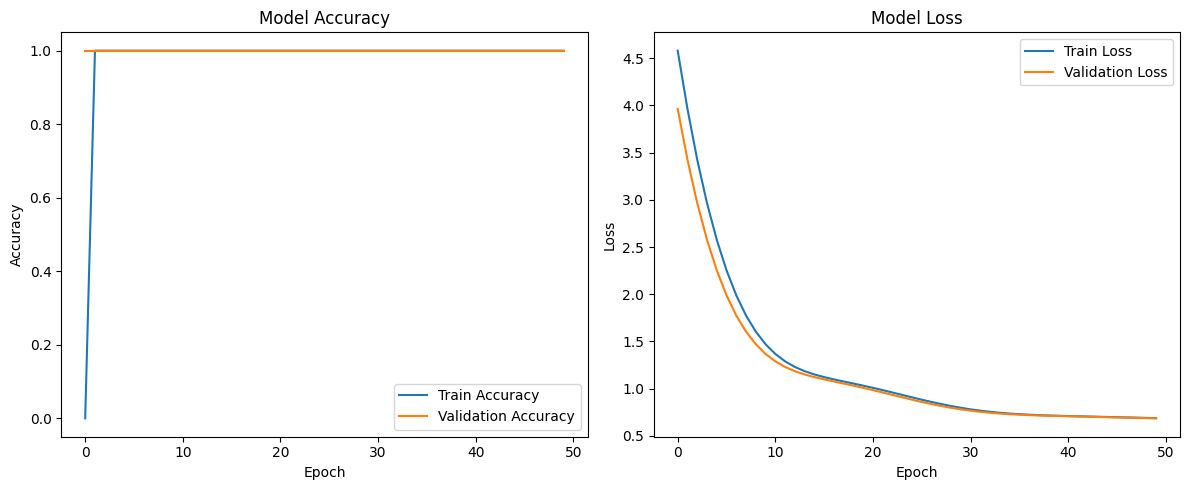

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable where you stored the model training results
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training_history(history)

Overfitting:

If the model achieves high accuracy on the validation set quickly and the loss decreases linearly, it may be memorizing the training data rather than generalizing. This is particularly likely if the dataset is small or lacks diversity.
Data Leakage:

If the validation data contains samples that are very similar to the training data or if the model has seen validation samples during training (e.g., through incorrect data splitting), this can lead to misleadingly high accuracy.
Imbalanced Classes:

If one class dominates the dataset, the model might learn to always predict that class, resulting in high accuracy despite poor performance on the minority class.
Model Architecture Issues:

If the model is too complex for the amount of data available, it may fit the training data too well while still achieving high accuracy on the validation set.
Inadequate Evaluation Metrics:

Relying solely on accuracy can be misleading, especially in the case of imbalanced datasets. Consider using other metrics, such as precision, recall, or the F1 score, to get a better sense of the model's performance.

Sure! Here’s a detailed breakdown of how the 3D CNN model code works, explaining each component and its purpose:

### Code Breakdown

#### 1. Importing Libraries
```python
from keras import layers, models
```
- This imports the necessary modules from the Keras library. `layers` is used to create different layers for the model, while `models` is used to define and compile the model structure.

#### 2. Defining the Model Function
```python
def build_3dcnn(input_shape):
    inputs = layers.Input(shape=input_shape)
```
- The function `build_3dcnn` is defined to create the 3D CNN model. It takes `input_shape` as an argument, which specifies the shape of the input data (e.g., number of frames, height, width, channels).
- `layers.Input` creates an input layer that will accept the data of the specified shape.

#### 3. Convolutional Layers
Each convolutional layer processes the input data to extract features.

**First Convolutional Block:**
```python
x = layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
```
- `layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same')`: Creates a 3D convolutional layer with 32 filters, each with a 3x3x3 kernel. The `padding='same'` means the output size will be the same as the input size.
- `layers.BatchNormalization()`: Normalizes the output of the previous layer to improve stability and speed up training.
- `layers.Activation('relu')`: Applies the ReLU (Rectified Linear Unit) activation function, which introduces non-linearity into the model.
- `layers.MaxPooling3D(pool_size=(2, 2, 2))`: Down-samples the feature maps by taking the maximum value in each 2x2x2 region, reducing the spatial dimensions.

**Second and Third Convolutional Blocks:**
- The second and third blocks follow the same structure as the first block, but with 64 and 128 filters, respectively. The pooling size for the third block is adjusted to `(1, 2, 2)` to control the dimensionality reduction.

#### 4. Flattening the Output
```python
x = layers.Flatten()(x)
```
- `layers.Flatten()`: Converts the multi-dimensional output from the last convolutional block into a 1D vector. This prepares the data for the fully connected (dense) layers.

#### 5. Fully Connected Layers
```python
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
```
- `layers.Dense(128)`: Creates a dense layer with 128 neurons. This layer is fully connected to the previous layer.
- `layers.BatchNormalization()`: Normalizes the output of the dense layer to improve training stability.
- `layers.Activation('relu')`: Applies the ReLU activation function to introduce non-linearity.
- `layers.Dropout(0.5)`: Randomly drops 50% of the neurons during training to prevent overfitting.

#### 6. Output Layer
```python
outputs = layers.Dense(1, activation='sigmoid')(x)
```
- `layers.Dense(1, activation='sigmoid')`: Creates the output layer with 1 neuron and a sigmoid activation function. This is suitable for binary classification tasks (normal vs. abnormal).

#### 7. Compiling the Model
```python
model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```
- `models.Model(inputs, outputs)`: Creates the model by specifying the input and output layers.
- `model.compile(...)`: Compiles the model, specifying the optimizer (`'adam'`), the loss function (`'binary_crossentropy'` for binary classification), and metrics to evaluate during training (`['accuracy']`).

### Summary
- **Input Layer**: Accepts the 3D input data.
- **Convolutional Layers**: Extract features from the input data using multiple filters and down-sampling through pooling.
- **Flatten Layer**: Converts the 3D feature maps into a 1D vector.
- **Dense Layers**: Process the flattened features, with Batch Normalization and Dropout to improve training.
- **Output Layer**: Produces the final prediction for binary classification.
- **Compilation**: Prepares the model for training by specifying the optimizer, loss function, and metrics.

### Why It May Not Be Performing Well
1. **Overfitting**: If the model memorizes the training data instead of generalizing, it may show high accuracy on training but low accuracy on validation/testing data.
2. **Data Imbalance**: If there are unequal samples in the normal and abnormal classes, it could skew the model's predictions.
3. **Hyperparameter Settings**: The choice of learning rate, batch size, and model architecture may need tuning.

Let me know if you need further clarification on any part!